<a href="https://colab.research.google.com/github/Jarin160/driver-drowsiness-detection/blob/main/drowsiness_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/serenaraju/yawn-eye-dataset-new")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jarintasnimdiya0
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/serenaraju/yawn-eye-dataset-new


100%|██████████| 161M/161M [00:00<00:00, 1.12GB/s]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_path = "./yawn-eye-dataset-new/dataset_new/train"
test_path = "./yawn-eye-dataset-new/dataset_new/test"

In [ ]:
# Function to count images in each class
def count_class_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in training and test directories
train_class_counts = count_class_images(train_path)
test_class_counts = count_class_images(test_path)

print("Train Class Counts:", train_class_counts)
print("Test Class Counts:", test_class_counts)

Train Class Counts: {'Closed': 617, 'Open': 617, 'no_yawn': 616, 'yawn': 617}
Test Class Counts: {'Closed': 109, 'Open': 109, 'no_yawn': 109, 'yawn': 106}


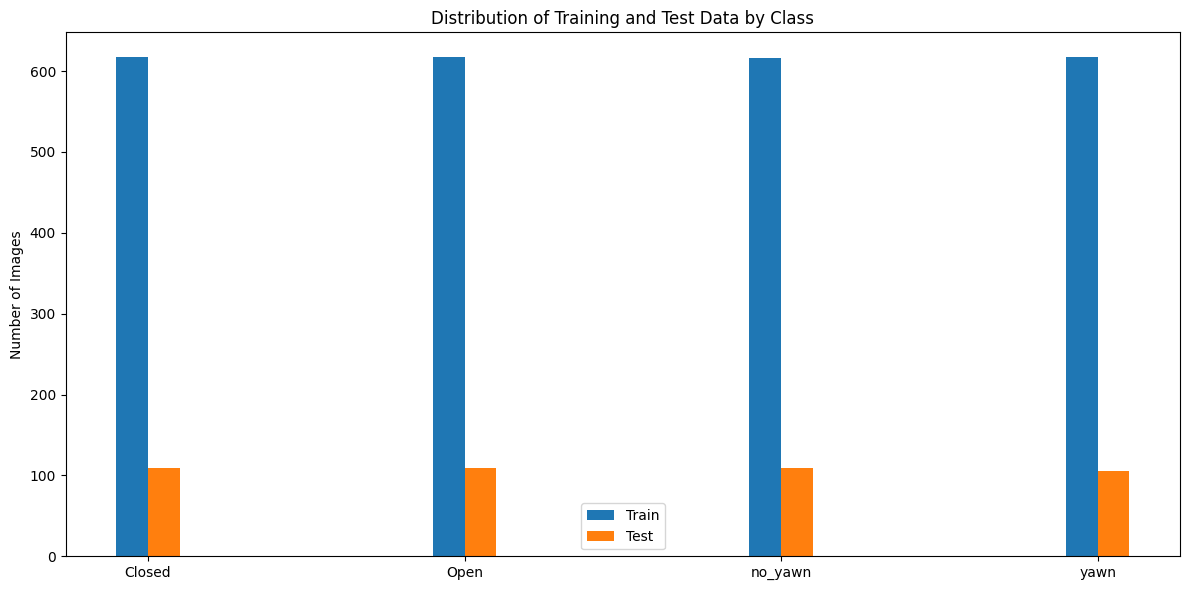

In [ ]:
class_names = list(train_class_counts.keys())
x = np.arange(len(class_names)) # the label locations
width = 0.1 # the width of the bars

plt.figure(figsize=(12, 6))

rects1 = plt.bar(x - width/2, [train_class_counts[name] for name in class_names], width, label='Train')
rects2 = plt.bar(x + width/2, [test_class_counts[name] for name in class_names], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Number of Images')
plt.title('Distribution of Training and Test Data by Class')
plt.xticks(x, class_names)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_datagen= ImageDataGenerator(rescale=1./255,
                                  rotation_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  validation_split=0.2)

train_data= train_datagen.flow_from_directory(train_path,
                                              target_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',
                                              subset='training' )

validation_data= train_datagen.flow_from_directory( train_path,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='validation')
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(test_path,
                                             target_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Found 1975 images belonging to 4 classes.
Found 492 images belonging to 4 classes.
Found 433 images belonging to 4 classes.


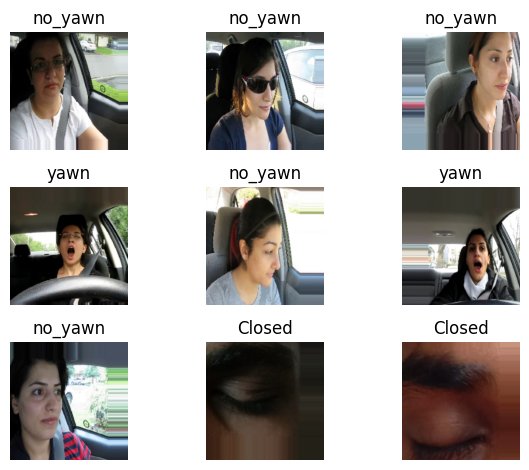

In [ ]:
for i in range(min(len(train_data[0][0]), 9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(train_data[0][0][i])

    class_names = list(train_data.class_indices.keys())
    plt.title(class_names[np.argmax(train_data[0][1][i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(224,224,3)))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

output = Dense(4,activation= 'softmax')(x)
model = Model(inputs=base_model.input, outputs= output)
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,855,972 (87.19 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 21,803,808 (83.17 MB)

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=10, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3)

callbacks=[earlystop,learning_rate]

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_data,
                    steps_per_epoch=train_data.samples//BATCH_SIZE,
                    validation_data=validation_data,
                    validation_steps=validation_data.samples//BATCH_SIZE,
                    callbacks=callbacks,
                    epochs=30)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 67s 785ms/step - accuracy: 0.6980 - loss: 0.8727 - val_accuracy: 0.7896 - val_loss: 0.4518 - learning_rate: 0.0010
Epoch 2/30
 1/61 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8125 - loss: 0.4423

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.8125 - loss: 0.4423 - val_accuracy: 0.7750 - val_loss: 0.4847 - learning_rate: 0.0010
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 632ms/step - accuracy: 0.8478 - loss: 0.3391 - val_accuracy: 0.8521 - val_loss: 0.3688 - learning_rate: 0.0010
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.7500 - loss: 0.4745 - val_accuracy: 0.8313 - val_loss: 0.4195 - learning_rate: 0.0010
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 616ms/step - accuracy: 0.8580 - loss: 0.3431 - val_accuracy: 0.7646 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 6/30
 1/61 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8125 - loss: 0.4294
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.8125 - loss: 0.4294 - val_accuracy: 0.7979 - val_loss: 0.5446 - learning_rate: 0.0010
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 43s 696ms/step - accuracy: 0.8680 - loss: 0.2993 - val_accu

In [ ]:
scores = model.evaluate(test_data)
print(f"Test Accuracy: {scores[1]*100}")
print(f"Test Loss: {scores[0]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 586ms/step - accuracy: 0.9165 - loss: 0.2070
Test Accuracy: 91.91685914993286
Test Loss: 0.20594188570976257


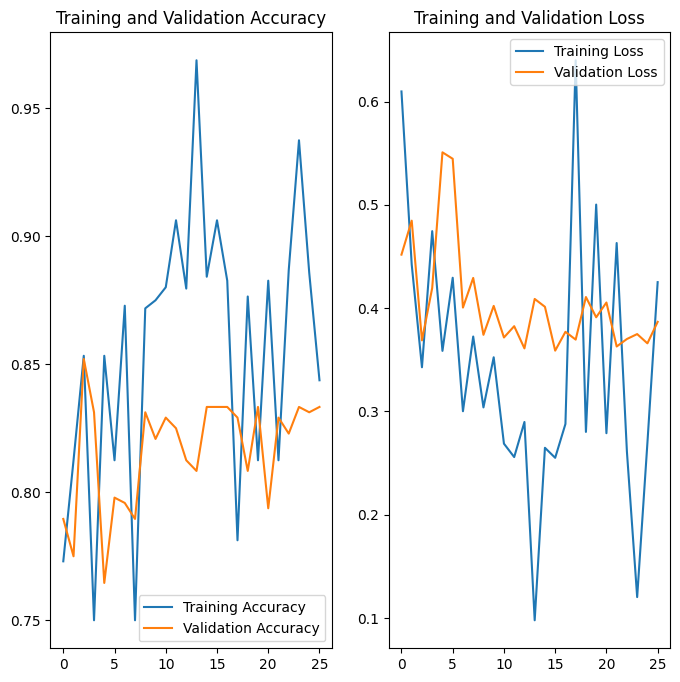

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(26), accuracy, label = 'Training Accuracy')
plt.plot(range(26), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(26), loss, label = 'Training Loss')
plt.plot(range(26), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


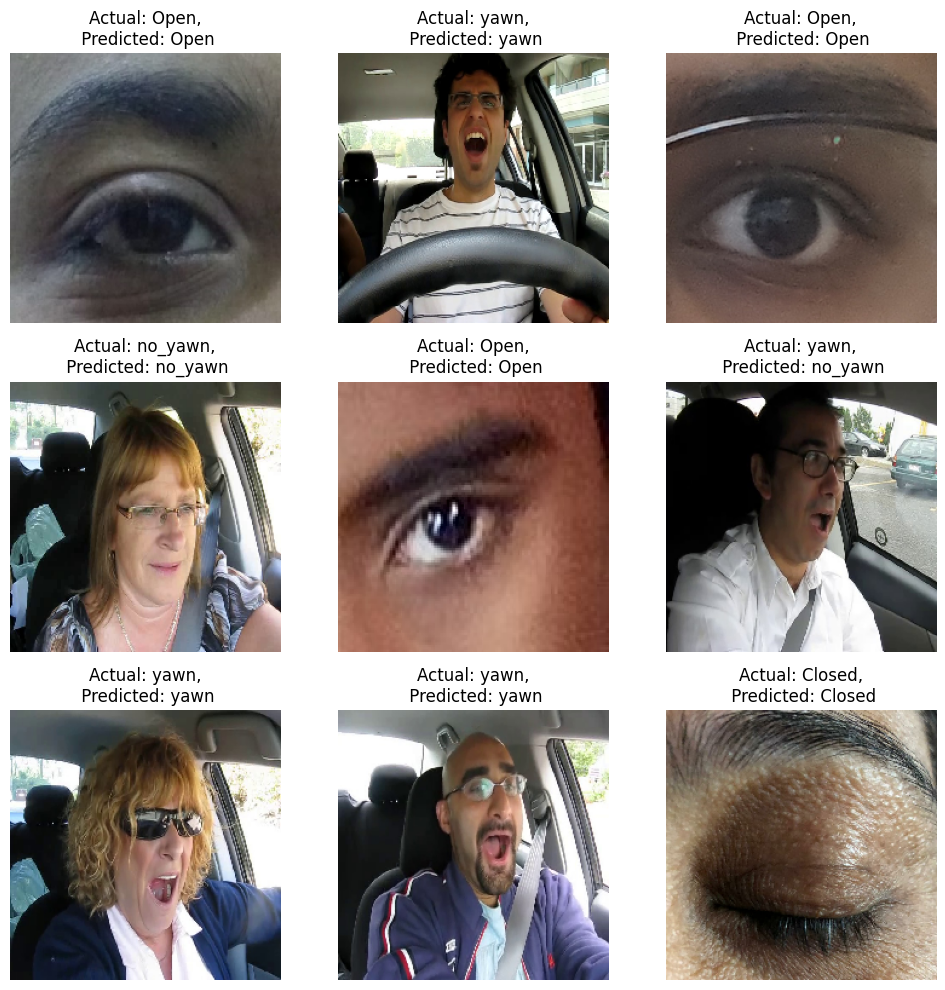

In [ ]:

def predict(model, img_array):
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class_index = np.argmax(score)
    predicted_class_name = class_names[predicted_class_index] # Use the existing class_names
    return predicted_class_name

# Get class names from the training data generator
cls_names = list(train_data.class_indices.keys())


plt.figure(figsize=(10,10))
# Get one batch of test data
images, labels = next(iter(test_data))

for i in range(min(len(images), 9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i])

    predicted_cls= predict(model, images[i])
    actual_cls = cls_names[np.argmax(labels[i])]

    plt.axis("off")
    plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls}")

plt.tight_layout()
plt.show()

In [ ]:
model.save("yawn_eye_model.h5")